In [52]:
#Import S&P500 Data
import yfinance as yf
import numpy as np
import pandas as pd
from pandas import DataFrame
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]

In [73]:
#Clean data and create intended features
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Label"] = 2 * (sp500["Tomorrow"] > sp500["Close"]).astype(int) - 1

#Only uses more recent data
sp500 = sp500.loc["2020-01-01":].copy()

#Includes rolling averages for additional features
horizons = [3,10,25]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    #Ratio of closing date from yesterday over rolling average of the closing dates
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    #Sum of labels divided by number of days in rolling average
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = (sp500.shift(1).rolling(horizon).sum()["Label"])/horizon
    
    new_predictors += [ratio_column, trend_column]
    
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Label,Close_Ratio_3,Trend_3,Close_Ratio_10,Trend_10,Close_Ratio_25,Trend_25
Date,,,,,,,,,,,,,
2020-02-07 00:00:00-05:00,3335.540039,0.001763,-0.004023,-0.002347,0.255130,0.010189,1,-8.274372,-1.000000,-14.484923,0.0,-3.763904,-0.12
2020-02-10 00:00:00-05:00,3318.280029,0.010240,-0.000154,0.010189,0.229589,-0.002412,-1,3.774321,-0.333333,7.900450,0.0,11.003477,-0.04
2020-02-11 00:00:00-05:00,3365.870117,0.002900,-0.003907,-0.002412,0.257863,0.002655,1,-1.333093,-0.333333,-5.931579,-0.2,-5.107765,-0.12
2020-02-12 00:00:00-05:00,3370.500000,0.003255,-0.000231,0.002655,0.273683,0.002389,-1,0.763630,0.333333,2.288163,0.0,4.173289,-0.04
2020-02-13 00:00:00-05:00,3365.899902,0.005701,-0.001598,0.002389,0.233183,0.000616,-1,2.723103,-0.333333,4.236884,-0.2,4.317683,-0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05 00:00:00-04:00,5158.950195,0.012256,-0.000337,0.008798,0.222436,-0.001723,-1,-4.141981,0.333333,-8.795014,0.2,116.284157,0.20
2024-04-08 00:00:00-04:00,5211.370117,0.001573,-0.002690,-0.001723,0.212208,-0.001365,1,0.453798,-0.333333,1.698752,0.0,5.824109,0.12
2024-04-09 00:00:00-04:00,5217.029785,0.001491,-0.010782,-0.001365,0.223745,-0.001401,-1,-0.716951,0.333333,1.212681,0.0,3.897548,0.20


In [74]:
#Makes the data into percentages so it can be encoded into the quantum circuit
sp500["Close"] = (sp500["Close"]-sp500["Open"])/sp500["Open"]
sp500["High"] = (sp500["High"]-sp500["Open"])/sp500["Open"]
sp500["Low"] = (sp500["Low"]-sp500["Open"])/sp500["Open"]
sp500["Volume"] = (sp500["Volume"] - sp500["Volume"].min())/sp500["Volume"].max()

#Drops data that we don't want to use in training
predictors = sp500.drop(["Open", "Tomorrow","Label"], axis=1)
predictors = DataFrame.to_numpy(predictors)
labels = (DataFrame.to_numpy(sp500))[:,6]
num_features = np.size(predictors, axis=1)

In [75]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

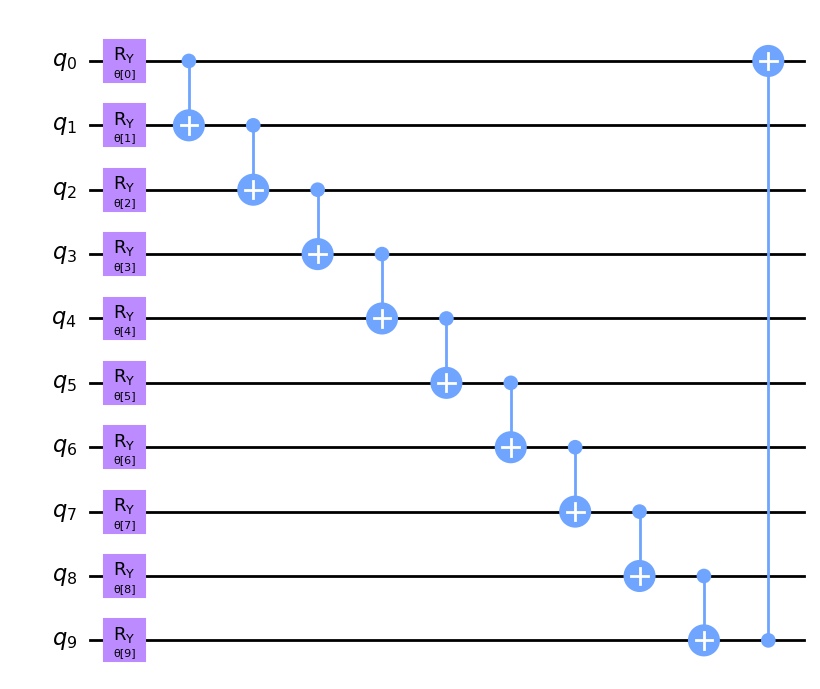

In [76]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = num_features
def parametrized_gates(params):
    target = QuantumCircuit(num_features)
        
    for i in range(num_features):
        target.ry(params[i], i)
        
    for i in range(num_features-1):
        target.cx(i, i+1)
        
    target.cx(9,0)
    
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=num_params)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

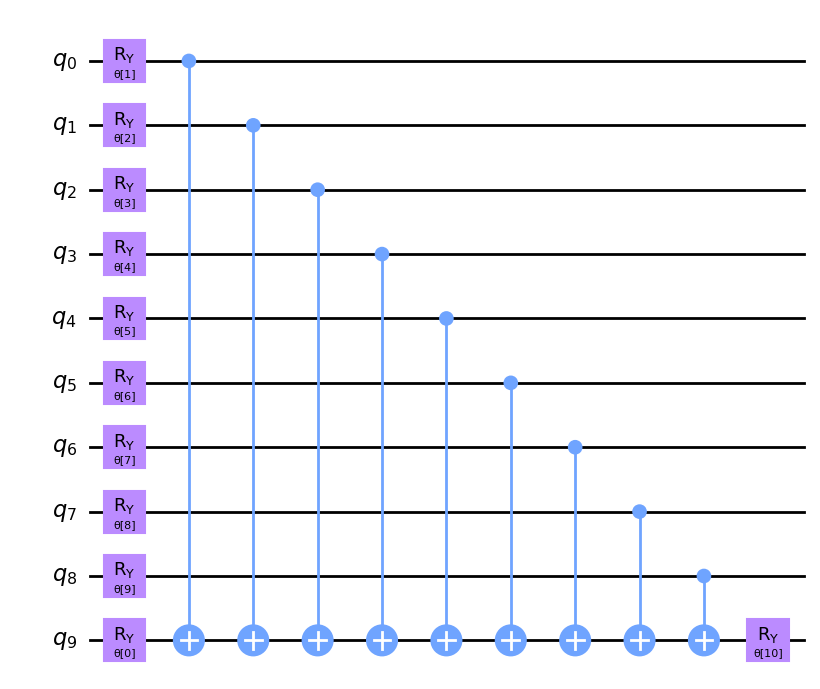

In [77]:
#Circuit to help with dimensionality reduction and combine two qubits into one
def pool_circuit(params):
    target = QuantumCircuit(num_features)
    
    target.ry(params[0], num_features-1)
    for i in range(num_features-1):
        target.ry(params[i+1], i)
        target.cx(i,num_features-1)
    
    target.ry(params[num_features], num_features-1)

    return target


params = ParameterVector("θ", length=num_features+1)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

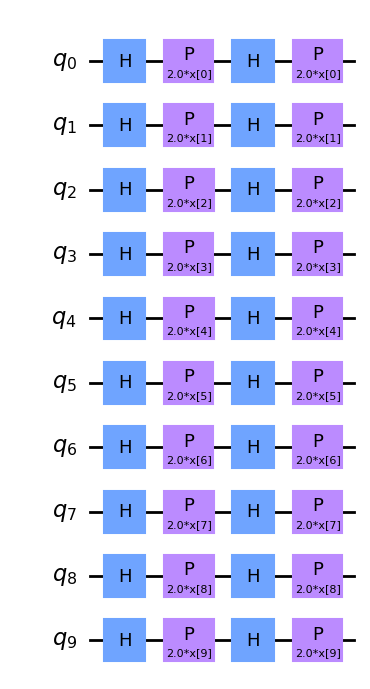

In [78]:
#Qiskits default circuit for encoding data
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(np.size(predictors, axis=1))
feature_map.decompose().draw("mpl", style="clifford")

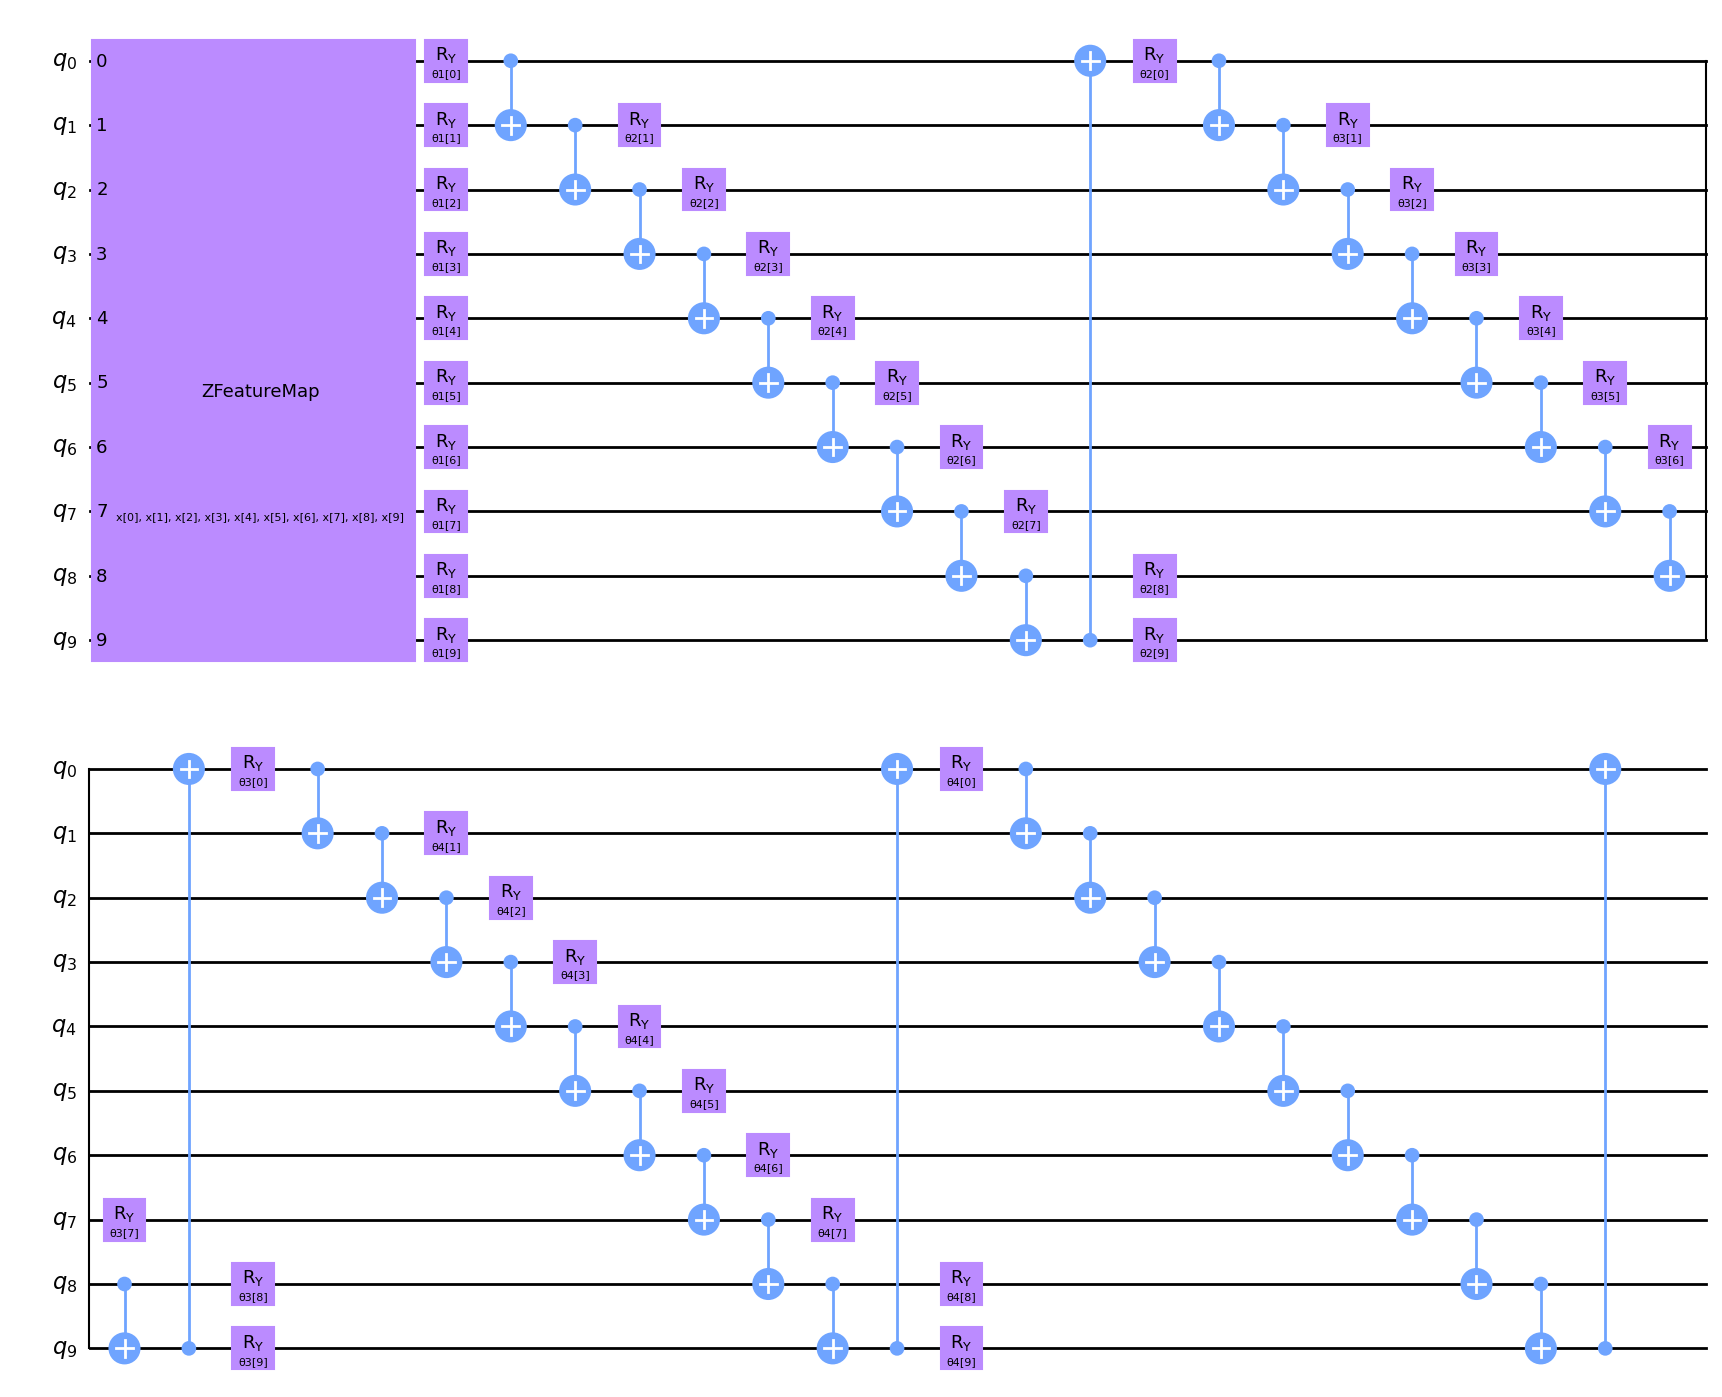

In [93]:
#Sets up full circuit with inputs and network
network = parametrized_gates(ParameterVector("θ1", length=num_params))
network.compose(parametrized_gates(ParameterVector("θ2", length=num_params)), inplace=True)
network.compose(parametrized_gates(ParameterVector("θ3", length=num_params)), inplace=True)
network.compose(parametrized_gates(ParameterVector("θ4", length=num_params)), inplace=True)
ml_circuit = QuantumCircuit(num_features)
ml_circuit.compose(feature_map, inplace=True)
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [94]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

In [95]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("Z" + "I" * 9, 1)])
qnn = EstimatorQNN(
    circuit=ml_circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=network.parameters,
)

In [104]:
#Function used in classifier to plot objective function at each iteration
max_iters = 600
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    #print(len(objective_func_vals)/max_iters*100, end="\r")
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [105]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=max_iters),
    callback=callback_graph
)

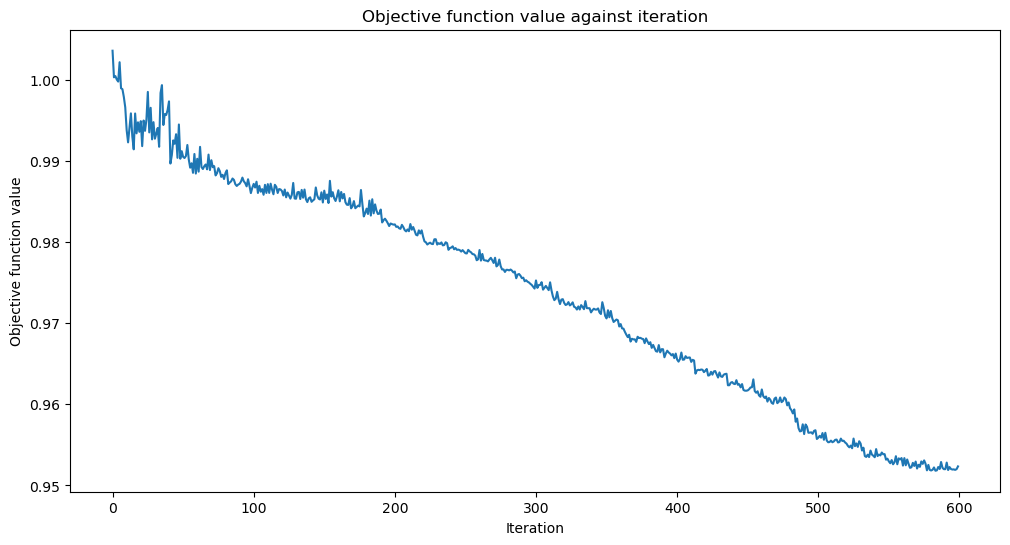

Accuracy from the test data : 60.7%


In [106]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(predictors, labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(predictors, labels), 2)}%")

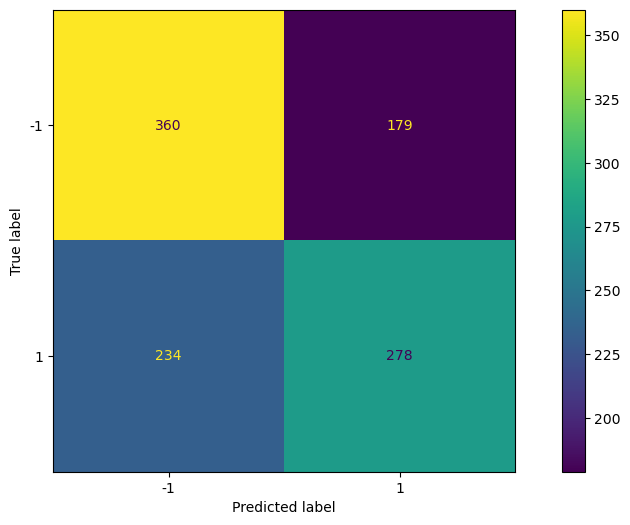

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, classifier.predict(predictors))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1,1])
display.plot()
plt.show()